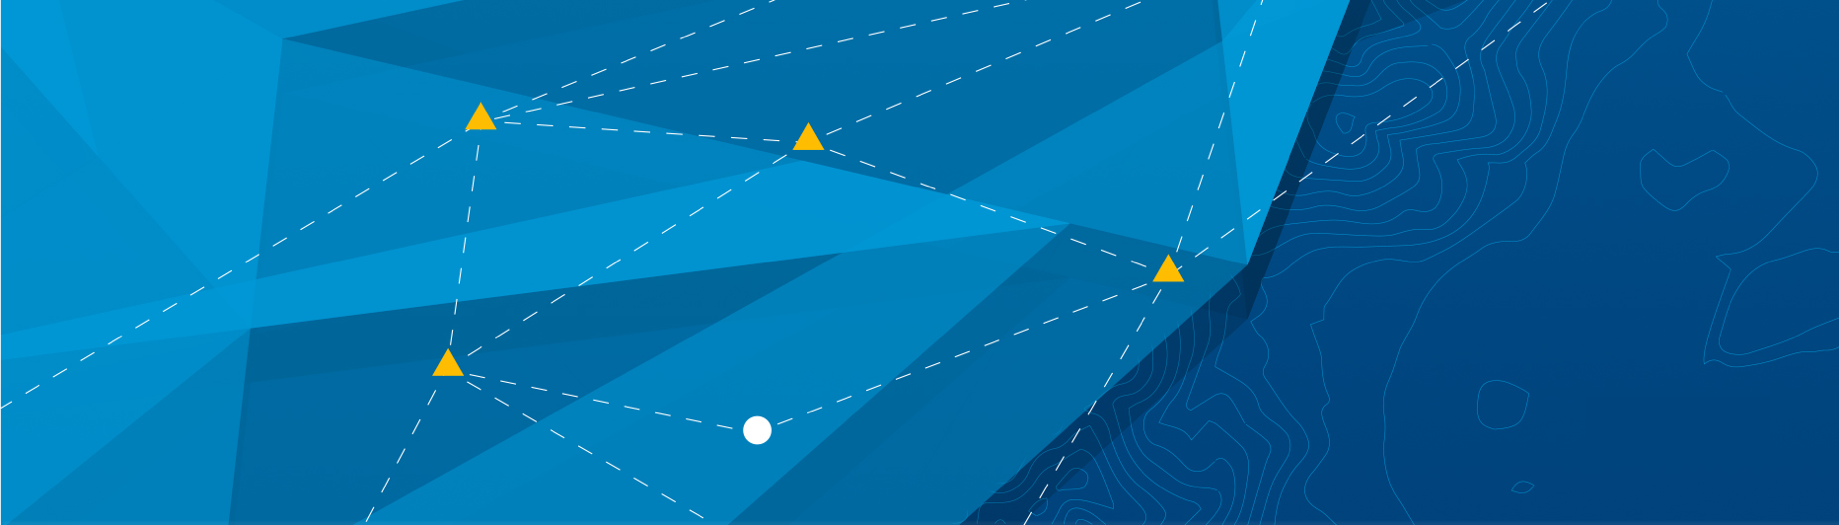

<center>
    
    
 ## Model Selection trough Performance Criteria for an Object Detection Task 
    
___

<center>

##### Pablo de la Asunción Cumbrera Conde

### Índice

 - Introducción
     - Objetivo
     - Descripción de la muestra
     - Dl. models & weights
     - Requeriments
     - Acknowledges
     - Rendimiento previo
 - Librerias y Set Up
 - Model Definition
 - Model Activation
 - Results Comparison & Analysis
 - Exploratory Data Analysis
 - Conclusiones

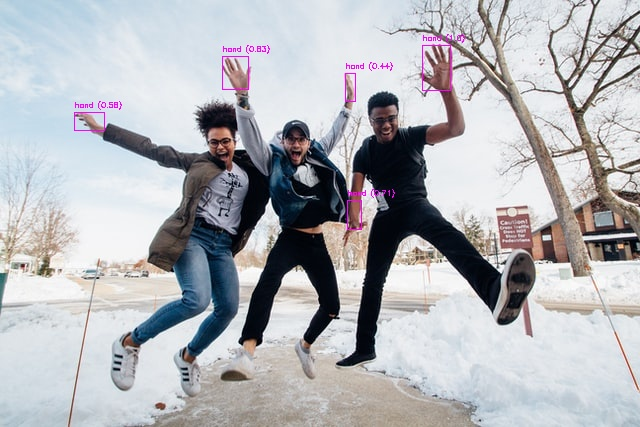

### Introducción
____

El siguiente proyecto tiene como finalidad la elección del mejor modelo de entre cuatro posibles (Yolov3,Yolov3 Tiny, Yolov3 PRN y Yolov4 Tiny) para una tarea de detección de objetos. Para llevar a cabo dicha selección, nos basaremos en el rendimiento que muestran sobre un data set propio elaborado a partir de manos. 

#### Objetivo:
- Responder las siguientes preguntas: 
1. ¿Cuál de los cuatro modelos obtiene mejor rendimiento sobre nuestro Data Set? (Eficiencia)
2. ¿Cuál de los modelos tiene más precisión? (Eficacia)
3. ¿Cuál de los modelos tarda menos? (Recursos)
4. ¿Cuál consideramos más óptimo? (Elección)

- Descripción de la muestra: compuesta de 195 fotografías sobre las que se aplicaran las detecciones. Provienen de 6 videos diferentes con semejantes características físicas del que se han tomado frames aleatorios y mezclados (directorio).

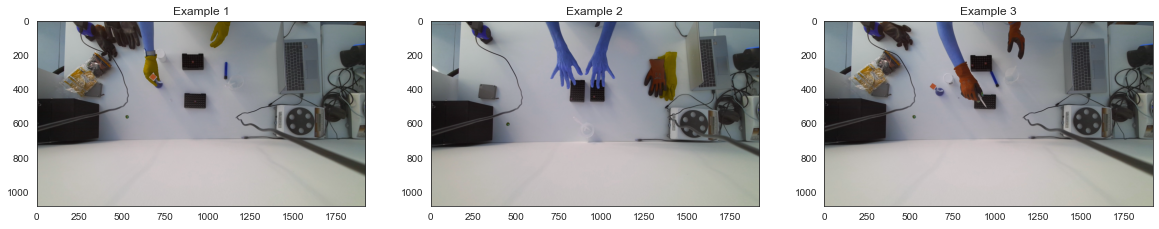

In [104]:
sns.set_style("white")
imex1=cv2.imread(r"C:\Users\pablo.cumbrera\Documents\Data\Raw DATA\OficeHand\images\mixed\frame946.jpg")
imex2=cv2.imread(r"C:\Users\pablo.cumbrera\Documents\Data\Raw DATA\OficeHand\images\mixed\frame4654.jpg")
imex3=cv2.imread(r"C:\Users\pablo.cumbrera\Documents\Data\Raw DATA\OficeHand\images\mixed\frame180.jpg")

fig = plt.figure(figsize=(20,12))
plt.subplot(331)
plt.title('Example 1')
plt.imshow(imex1)

plt.subplot(332)
plt.title('Example 2')
plt.imshow(imex2)

plt.subplot(333)
plt.title('Example 3')
plt.imshow(imex3)

Download models & Weights:

- YOLOv3 Cross-Dataset
	- [Configuration](https://github.com/cansik/yolo-hand-detection/releases/download/pretrained/cross-hands.cfg)
	- [Weights](https://github.com/cansik/yolo-hand-detection/releases/download/pretrained/cross-hands.weights)
- YOLOv3-tiny Cross-Hands
	- [Configuration](https://github.com/cansik/yolo-hand-detection/releases/download/pretrained/cross-hands-tiny.cfg)
	- [Weights](https://github.com/cansik/yolo-hand-detection/releases/download/pretrained/cross-hands-tiny.weights)
- YOLOv3-tiny-prn Cross-Hands
	- [Configuration](https://github.com/cansik/yolo-hand-detection/releases/download/pretrained/cross-hands-tiny-prn.cfg)
	- [Weights](https://github.com/cansik/yolo-hand-detection/releases/download/pretrained/cross-hands-tiny-prn.weights)
- YOLOv4-Tiny Cross-Hands
	- [Configuration](https://github.com/cansik/yolo-hand-detection/releases/download/pretrained/cross-hands-yolov4-tiny.cfg)
	- [Weights](https://github.com/cansik/yolo-hand-detection/releases/download/pretrained/cross-hands-yolov4-tiny.weights)

- Project based on: https://github.com/cansik/yolo-hand-detection

- Requeriments: opencv-python
opencv-contrib-python
numpy

About: Trained by *[cansik](https://github.com/cansik)*, datasets are described in the readme and fall under the terms and conditions of their owners.

All the demo images have been downloaded from [unsplash.com](https://unsplash.com/):

Tim Marshall, Zachary Nelson, John Torcasio, Andy Falconer, Sherise, Alexis Brown

#### Rendimiento Previo:

- Rendimiento Yolov3 

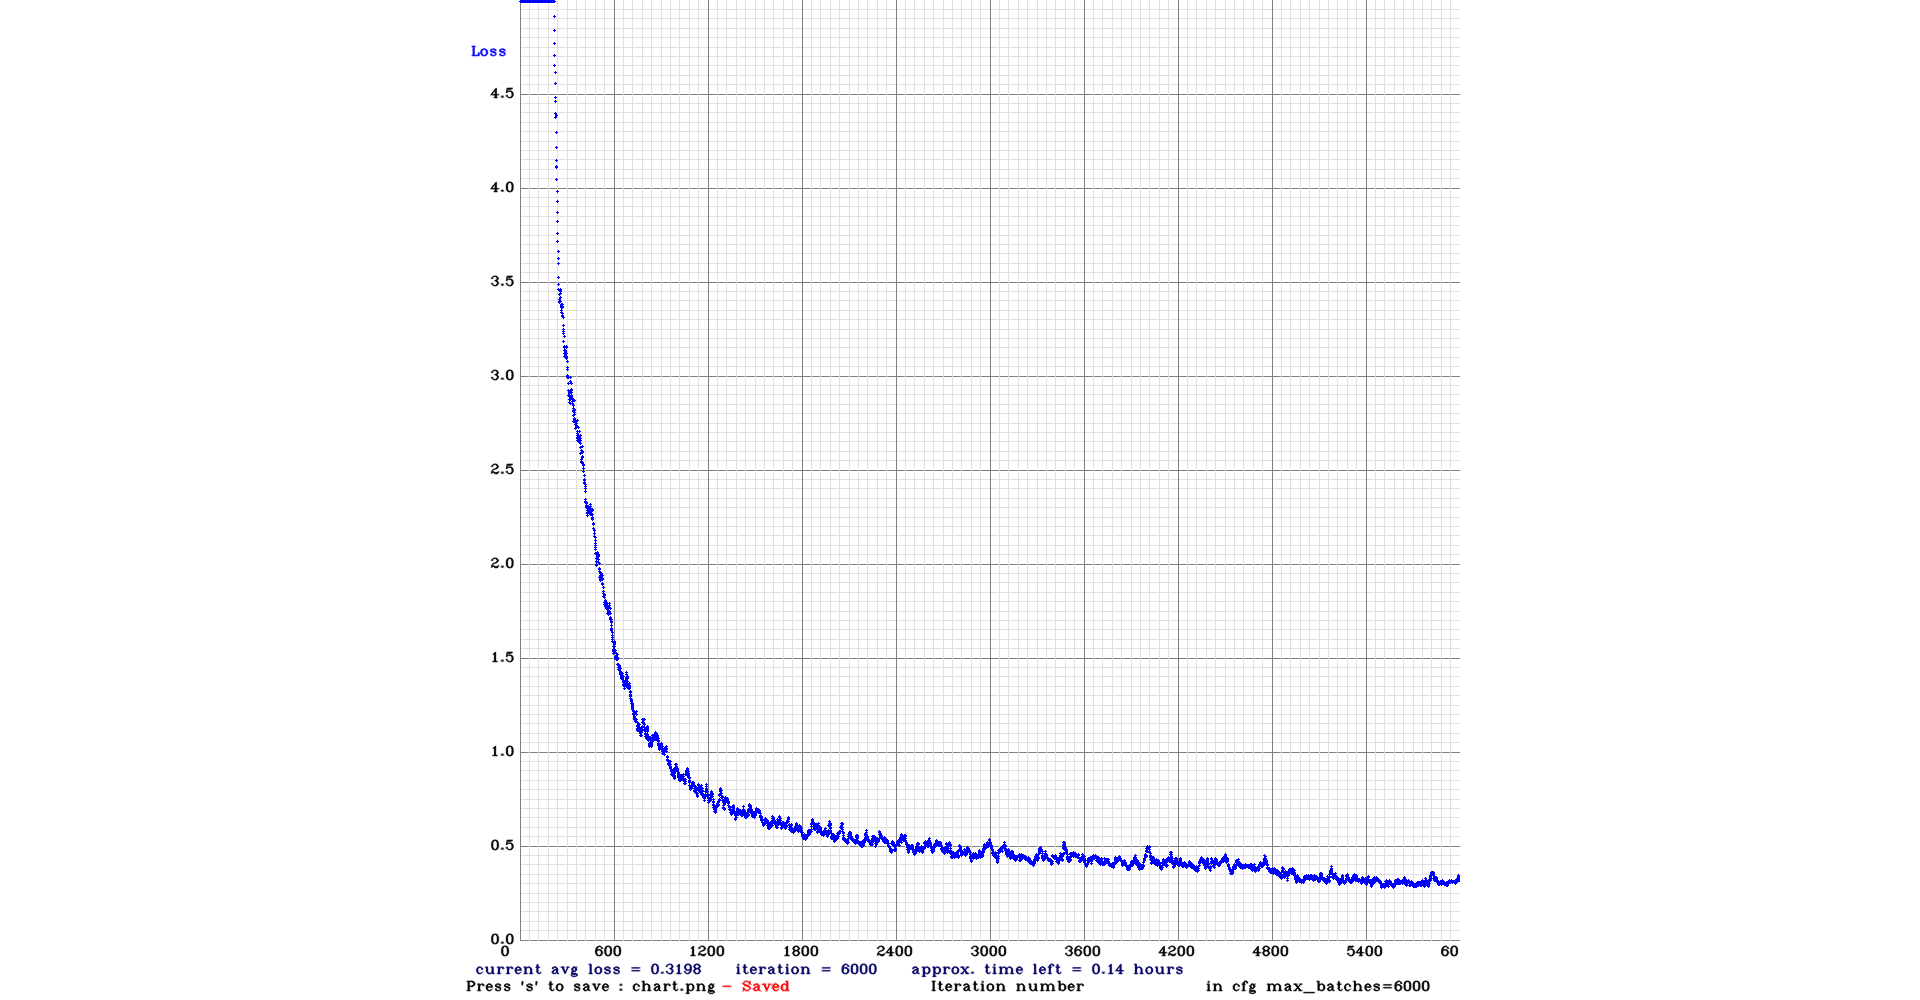

- Rendimiento Yolov3 Tiny
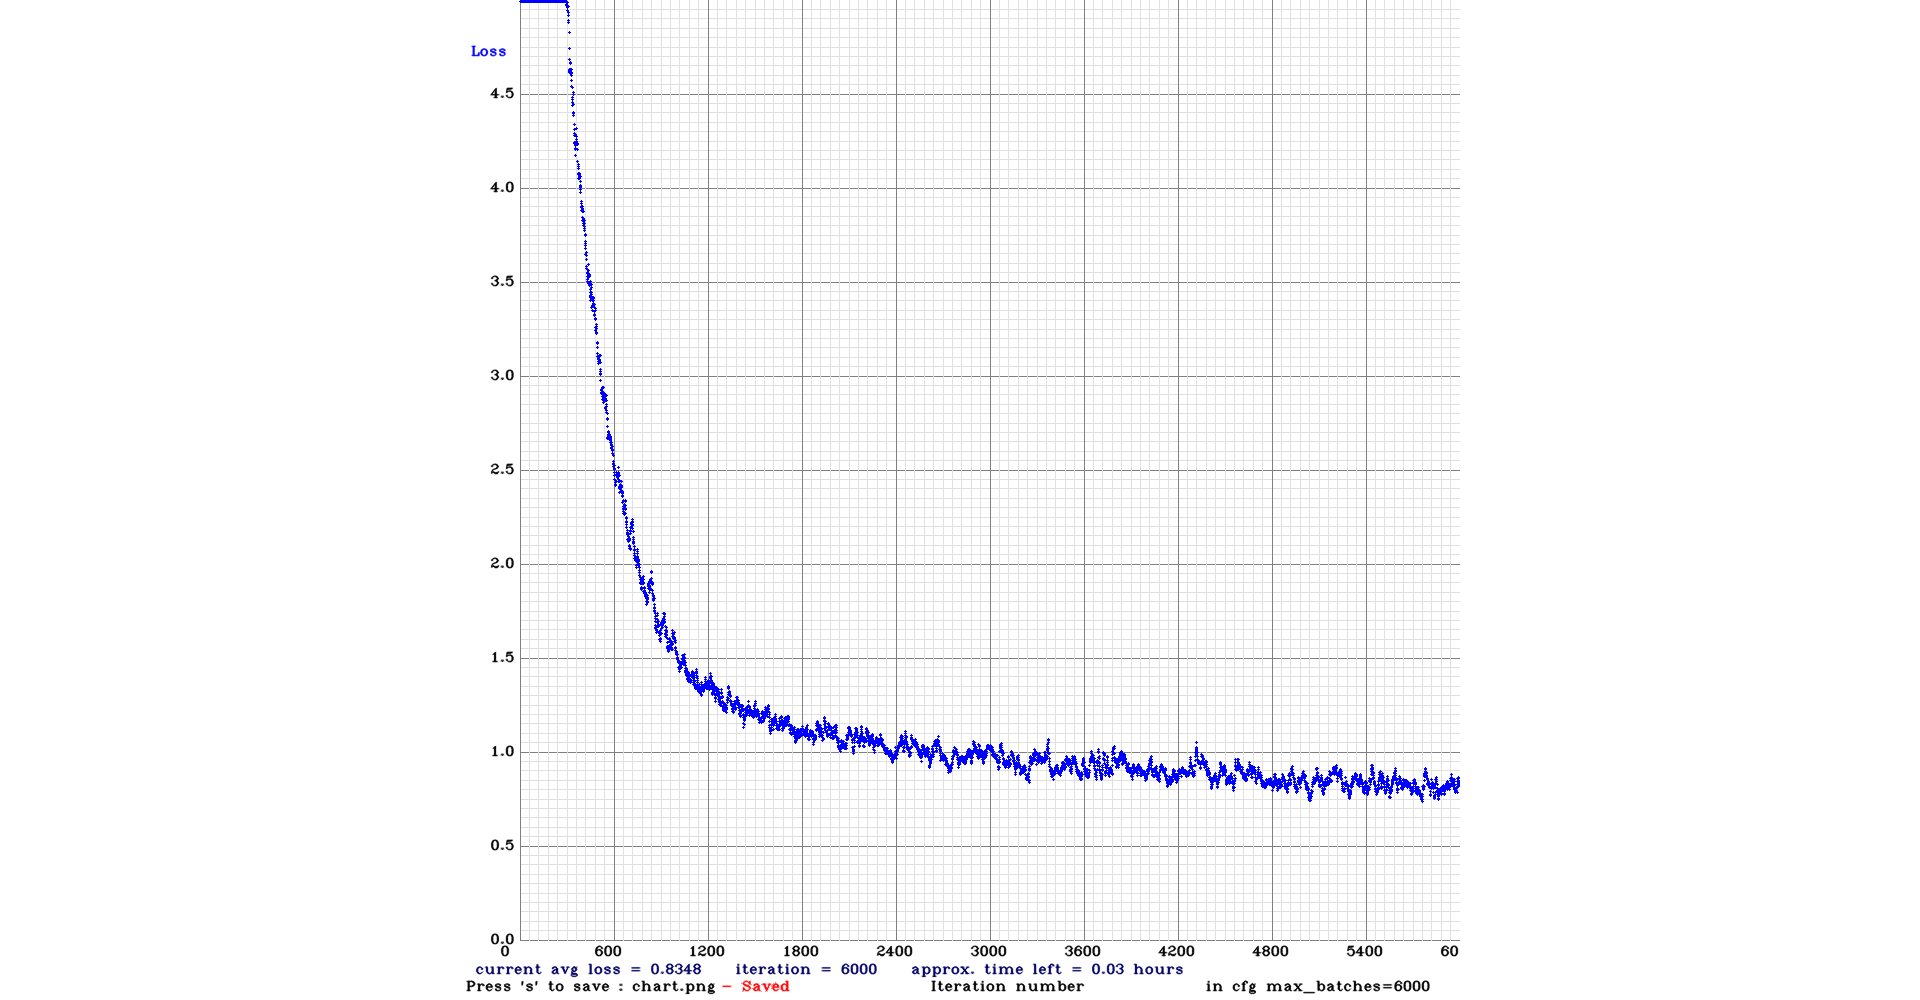

- Rendimiento Yolov3 Tiny Pnr 
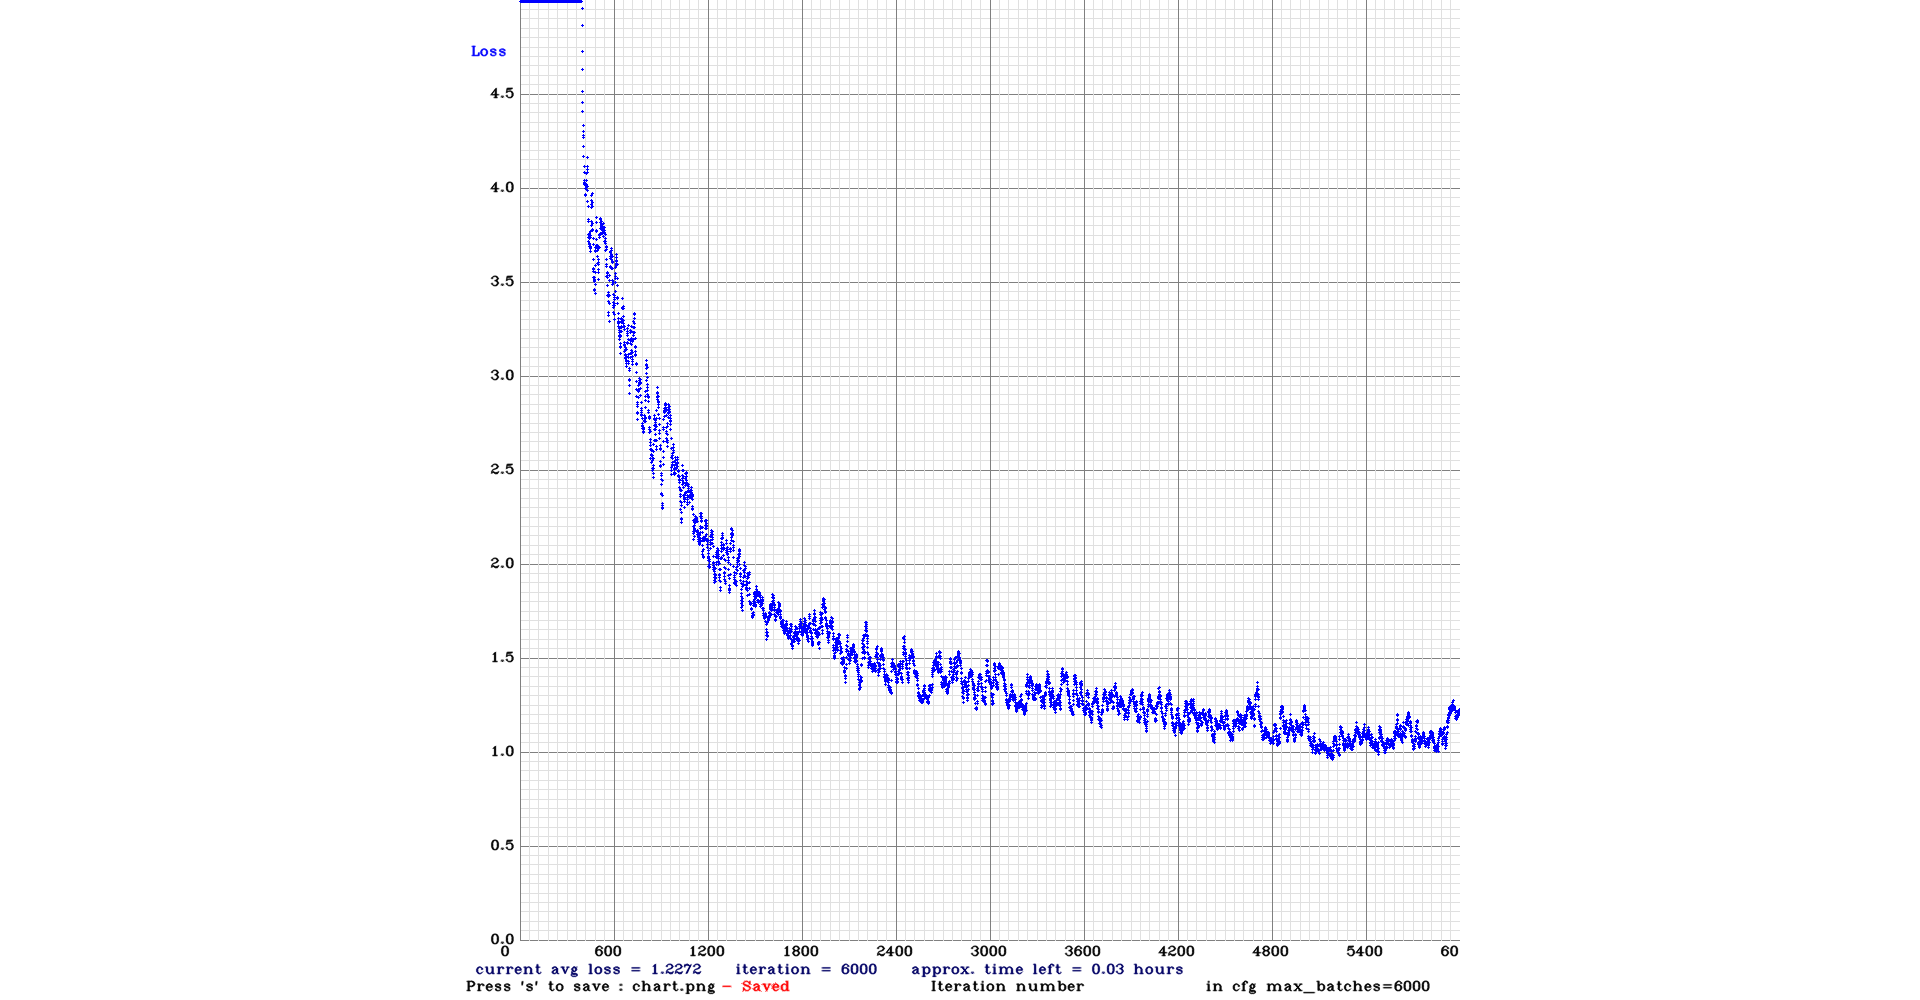

- Rendimiento Yolov4 Tiny
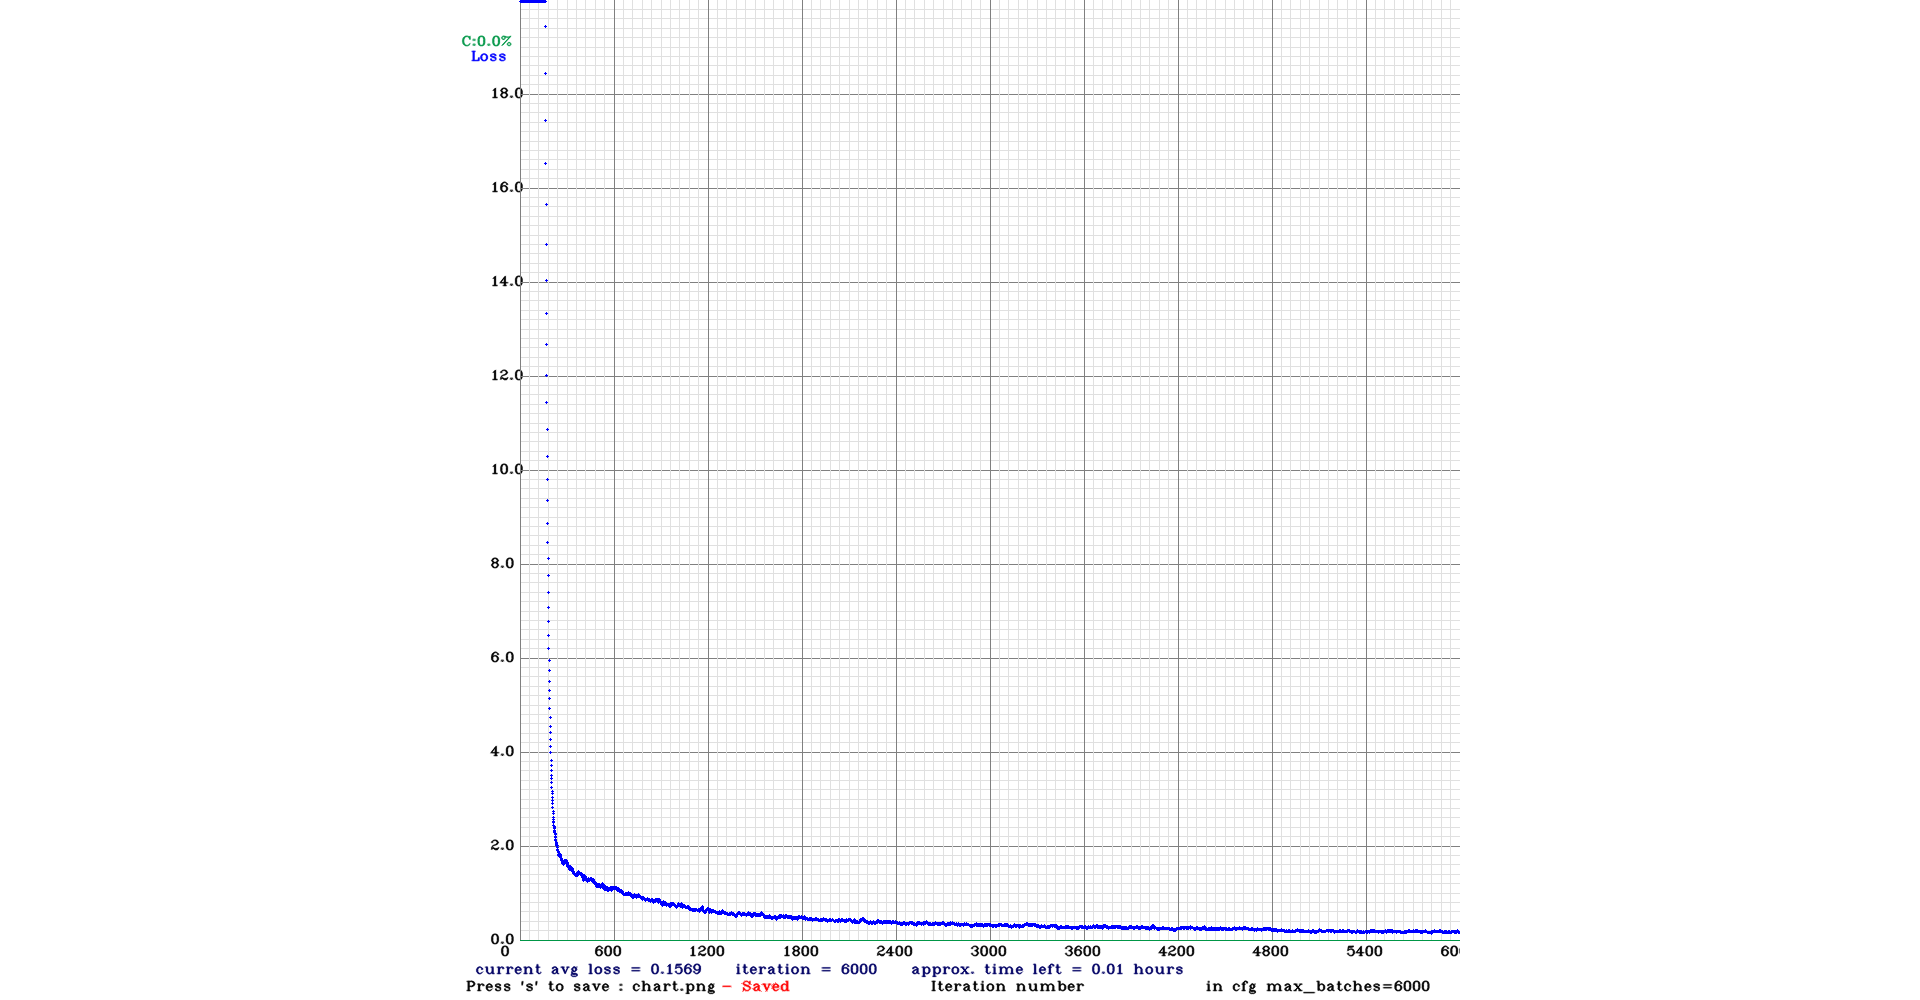

### Librerias
___

In [1]:
import argparse
import glob
import os
import cv2
import numpy as np
import time
import pathlib
import tkinter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
#Creamos Data Frame donde almacenaremos nuestros datos

yolov3_df=pd.DataFrame()
yolov3t_df=pd.DataFrame()
yolov3prn_df=pd.DataFrame()
yolov4t_df=pd.DataFrame()

### Model Definition
___

In [3]:
class YOLO:

    def __init__(self, config, model, labels, size=416, confidence=0.5, threshold=0.3):
        self.confidence = confidence
        self.threshold = threshold
        self.size = size

        self.labels = labels
        try:
            self.net = cv2.dnn.readNetFromDarknet(config, model)
        except:
            raise ValueError("Couldn't find the models!\nDid you forget to download them manually (and keep in the correct directory, models/) or run the shell script?")

    def inference_from_file(self, file):
        mat = cv2.imread(file)
        return self.inference(mat)

    def inference(self, image):
        
        ih, iw = image.shape[:2]

        ln = self.net.getLayerNames()
        ln = [ln[i[0] - 1] for i in self.net.getUnconnectedOutLayers()]

        blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (self.size, self.size), swapRB=True, crop=False)
        self.net.setInput(blob)
        start = time.time()
        layerOutputs = self.net.forward(ln)
        end = time.time()
        inference_time = end - start

        boxes = []
        confidences = []
        classIDs = []

        for output in layerOutputs:
            # loop over each of the detections
            for detection in output:
                # extract the class ID and confidence (i.e., probability) of
                # the current object detection
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]
                # filter out weak predictions by ensuring the detected
                # probability is greater than the minimum probability
                if confidence > self.confidence:
                    # scale the bounding box coordinates back relative to the
                    # size of the image, keeping in mind that YOLO actually
                    # returns the center (x, y)-coordinates of the bounding
                    # box followed by the boxes' width and height
                    box = detection[0:4] * np.array([iw, ih, iw, ih])
                    (centerX, centerY, width, height) = box.astype("int")
                    # use the center (x, y)-coordinates to derive the top and
                    # and left corner of the bounding box
                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))
                    # update our list of bounding box coordinates, confidences,
                    # and class IDs
                    boxes.append([x, y, int(width), int(height)])
                    confidences.append(float(confidence))
                    classIDs.append(classID)

        idxs = cv2.dnn.NMSBoxes(boxes, confidences, self.confidence, self.threshold)

        results = []
        if len(idxs) > 0:
            for i in idxs.flatten():
                # extract the bounding box coordinates
                x, y = (boxes[i][0], boxes[i][1])
                w, h = (boxes[i][2], boxes[i][3])
                id = classIDs[i]
                confidence = confidences[i]

                results.append((id, self.labels[id], confidence, x, y, w, h))

        return iw, ih, inference_time, results


### Model Activation
___

- Creamos carpetas con nuestros resultados, asi como almacenamos cada elemento en un DF

In [4]:
#### PARAMETROS

###DATAFRAME
df= yolov3t_df
df_outname = 'yolov3tresults.csv'
#IN
IMG_PATH = r"C:\Users\pablo.cumbrera\Documents\Data\Raw DATA\OficeHand\images\mixed"

#OUT
OUTPUT_PATH_v3 = r"C:\Users\pablo.cumbrera\Documents\Data\Raw DATA\OficeHand\images\testing\yolov3t"

#PATHS A MODELOS
path3=r"C:\Users\pablo.cumbrera\Downloads\yolo-hand-detection-master\models\cross-hands.cfg"
path3_w=r"C:\Users\pablo.cumbrera\Downloads\yolo-hand-detection-master\models\cross-hands.weights"
path3t=r"C:\Users\pablo.cumbrera\Downloads\yolo-hand-detection-master\models\cross-hands-tiny.cfg"
path3t_w= r"C:\Users\pablo.cumbrera\Downloads\yolo-hand-detection-master\models\cross-hands-tiny.weights"
pathprn= r"C:\Users\pablo.cumbrera\Downloads\yolo-hand-detection-master\models\cross-hands-tiny-prn.cfg"
pathprn_w= r"C:\Users\pablo.cumbrera\Downloads\yolo-hand-detection-master\models\cross-hands-tiny-prn.weights"
path4t= r"C:\Users\pablo.cumbrera\Downloads\yolo-hand-detection-master\models\cross-hands-yolov4-tiny.cfg"
path4t_w= r"C:\Users\pablo.cumbrera\Downloads\yolo-hand-detection-master\models\cross-hands-yolov4-tiny.weights"

- Pasamos cada modelo a la base de datos y los guardamos en diferentes dataframes

In [105]:
ap = argparse.ArgumentParser()
ap.add_argument('-i', '--images', default= IMG_PATH, help='Path to images or image file')
ap.add_argument('-n', '--network', default="tiny", help='Network Type: normal / tiny / prn / v4-tiny')
ap.add_argument('-d', '--device', default=0, help='Device to use')
ap.add_argument('-s', '--size', default=416, help='Size for yolo')
ap.add_argument('-c', '--confidence', default=0.25, help='Confidence for yolo')

#args = ap.parse_args()

args = ap.parse_args(args=[])

if args.network == "normal":
    print("loading yolo...")
    yolo = YOLO(path3,path3_w, ["hand"])

elif args.network == "prn":
    print("loading yolo-tiny-prn...")
    yolo = YOLO(pathprn, pathprn_w, ["hand"])

elif args.network == "v4-tiny":
    print("loading yolov4-tiny-prn...")
    yolo = YOLO(path4t,path4t_w , ["hand"])

else:
    print("loading yolo-tiny...")
    yolo = YOLO(path3t ,path3t_w , ["hand"])

yolo.size = int(args.size)
yolo.confidence = float(args.confidence)
print("extracting tags for each image...")

if args.images.endswith(".txt"):
    with open(args.images, "r") as myfile:
        lines = myfile.readlines()
        files = map(lambda x: os.path.join(os.path.dirname(args.images), x.strip()), lines)
else:
    files = sorted(glob.glob("%s/*.jpg" % args.images))

conf_sum = 0
detection_count = 0
counter = 0


#DF List
filename=[]
ev_time=[]
classes=[]
elements=[]
confidences=[]

for file in files:
    print(file)
    mat = cv2.imread(file)

    width, height, inference_time, results = yolo.inference(mat)
    new_name = "processed_file_{}_.jpg".format(counter)

    print("%s in %s seconds: %s classes found!" %
        (os.path.basename(file), round(inference_time, 2), len(results)))
        
    output = []

    cv2.namedWindow('image', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('image', 848, 640)
    
    #DF List
    detected_classes=[]
    detected_elements=[]
    detected_confidences=[]
    
    
    for detection in results:
        id, name, confidence, x, y, w, h = detection
        cx = x + (w / 2)
        cy = y + (h / 2)

        conf_sum += confidence
        detection_count += 1
        
        #DF List
        detected_classes.append(name)
        detected_confidences.append(confidence)
        
        # draw a bounding box rectangle and label on the image

        color = (255, 0, 255)
        cv2.rectangle(mat, (x, y), (x + w, y + h), color, 1)
        text = "%s (%s)" % (name, round(confidence, 2))
        cv2.putText(mat, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
            0.25, color, 1)

        print("%s with %s confidence" % (name, round(confidence, 2)))

    detected_elements.append(len(detected_classes))
    filename.append(file)
    ev_time.append(round(inference_time, 2))
    classes.append(detected_classes)
    confidences.append(detected_confidences)
    elements.append(detected_elements)
    
    print(OUTPUT_PATH_v3+"/"+new_name)
    cv2.imwrite(OUTPUT_PATH_v3+"/"+new_name, mat)
    counter +=1
    print("this is counter: ",counter)
    # show the output image

    #cv2.imshow('image', mat)
    #cv2.waitKey(0)

    
#DF
df['filename']=filename
df['time']=ev_time
df['classes']=classes
df['confidences']=confidences
df['elements']=elements
df.head()
df.to_csv(df_outname, index=False)

print("AVG Confidence: %s Count: %s" % (round(conf_sum / detection_count, 2), detection_count))
cv2.destroyAllWindows()

IndentationError: unexpected indent (<ipython-input-105-b5d7a413b849>, line 52)

### Result Comparison & Analysis
___

- Ejemplo de imagen de la muestra

Como podemos observar,  encontramos otro tipo de objetos que pueden confundir al modelo.

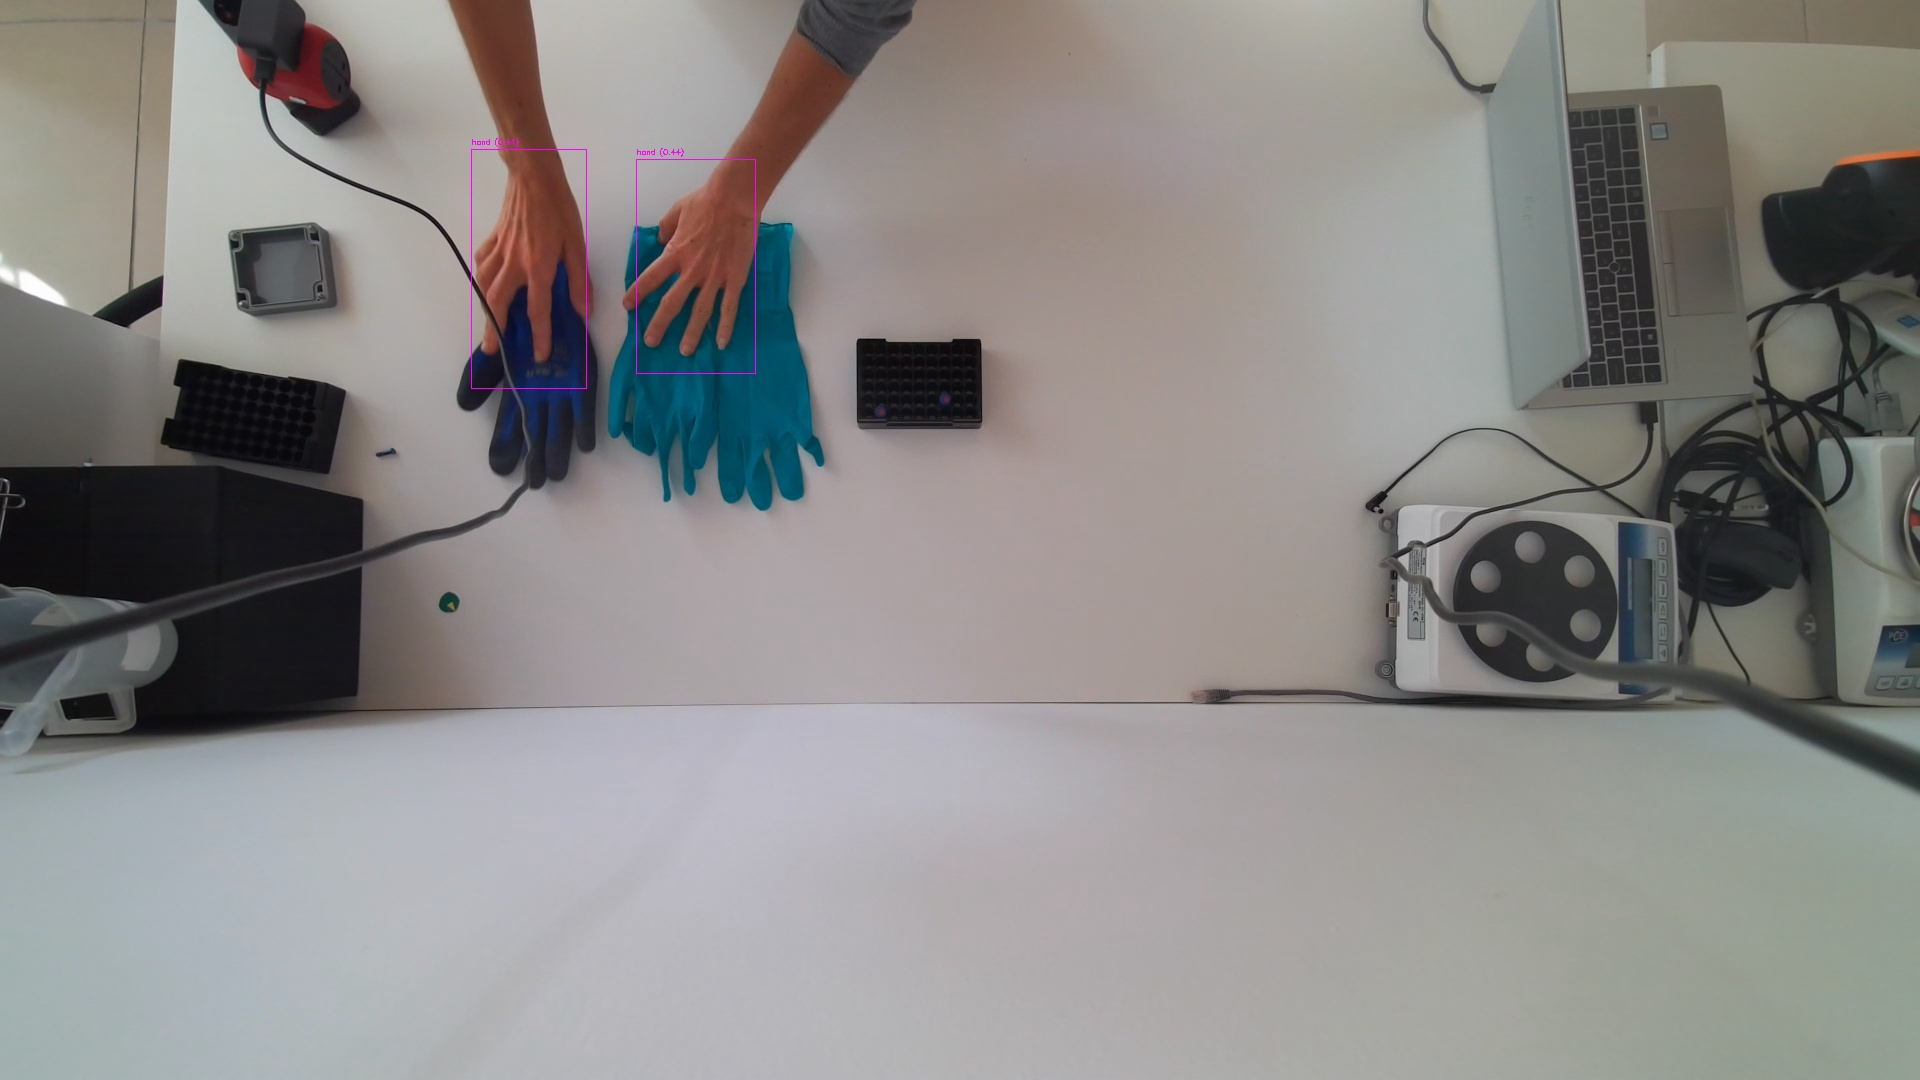

In [6]:
#Importamos los DF y los ordenamos

#IMPORT

def read(path):
    return pd.read_csv(path)
yolov3_df = read(r"C:\Users\pablo.cumbrera\Documents\Data\Raw DATA\imgescsv\yolov3results.csv")
yolov3t_df = read(r"C:\Users\pablo.cumbrera\Documents\Data\Raw DATA\imgescsv\yolov3tresults.csv")
yolov3prn_df = read(r"C:\Users\pablo.cumbrera\Documents\Data\Raw DATA\imgescsv\yolov3prnresults.csv")
yolov4t_df = read(r"C:\Users\pablo.cumbrera\Documents\Data\Raw DATA\imgescsv\yolov4tresults.csv")

#CREATE AN UNIQUE 'CONFIDENCES' DATAFRAME

conf1 = yolov3_df.drop(['classes','elements','time'], axis=1)
conf2 = yolov3t_df.drop(['filename','classes','elements','time'], axis=1)
conf3 = yolov3prn_df.drop(['filename','classes','elements','time'], axis=1)
conf4 = yolov4t_df.drop(['filename','classes','elements','time'], axis=1)
conf1.columns = ['filename','yv3']
conf2.columns = ['tiny']
conf3.columns = ['prn']
conf4.columns = ['yv4']

conf_df=pd.concat([conf1,conf2,conf3,conf4],axis=1)

#DROP

def dropcol(df):
    return df.drop(['filename'], axis=1)

yolov3_df = dropcol(yolov3_df)
yolov3t_df = dropcol(yolov3t_df)
yolov3prn_df = dropcol(yolov3prn_df)
yolov4t_df = dropcol(yolov4t_df)

In [7]:
#VISUALIZACIÓN ALEATORIA DE LA MUESTRA

def plot_pics(listdir):
    counter = 0
    for filename in os.listdir(listdir):
        filepath = listdir + "/"+ filename
        print(filepath)
        im = cv2.imread(filepath)
        image = tf.image.resize(im,(416,416))/255
        plt.imshow(im)
        
        if counter>5:
            break
        else:
            counter +=1
                      
#print("Yolov3: \n")
#os=os.listdir(r"C:\Users\pablo.cumbrera\Documents\Data\Raw DATA\OficeHand\images\testing\yolov3"
#plot_pics("C:/Users/pablo.cumbrera/Documents/Data/Raw DATA/OficeHand/images/testing/yolov3")

#print("Yolov3 Tiny: \n")
#os=os.listdir(r"C:\Users\pablo.cumbrera\Documents\Data\Raw DATA\OficeHand\images\testing\yolov3"
#plot_pics("C:/Users/pablo.cumbrera/Documents/Data/Raw DATA/OficeHand/images/testing/yolov3t")

#print("Yolov3prn: \n")
#os=os.listdir(r"C:\Users\pablo.cumbrera\Documents\Data\Raw DATA\OficeHand\images\testing\yolov3"
#plot_pics("C:/Users/pablo.cumbrera/Documents/Data/Raw DATA/OficeHand/images/testing/yolov3prn")

#print("Yolov4 Tiny: \n")
#os=os.listdir(r"C:\Users\pablo.cumbrera\Documents\Data\Raw DATA\OficeHand\images\testing\yolov3"
#plot_pics("C:/Users/pablo.cumbrera/Documents/Data/Raw DATA/OficeHand/images/testing/yolov4t")

In [8]:
def getuniques (df):
    return df.unique()
print("\nNumero de elementos (min-max) que ha visto cada modelo : \n")
print("YOLOV3",getuniques(yolov3_df['elements']))
print("YOLOV3 TINY", getuniques(yolov3t_df['elements']))
print("YOLOV3 PRN", getuniques(yolov3prn_df['elements']))
print("YOLOV4 TINY",getuniques(yolov4t_df['elements']))


Numero de elementos (min-max) que ha visto cada modelo : 

YOLOV3 ['[0]' '[2]' '[1]']
YOLOV3 TINY ['[0]' '[1]' '[2]']
YOLOV3 PRN ['[0]' '[1]']
YOLOV4 TINY ['[1]' '[2]' '[0]' '[3]']


In [9]:
def timing (df):
    return df['time'].value_counts()
print("\nDistribución de valores (sin repetir) de tiempo consumido en cada operación (sg): \n")
print("YOLOV3",getuniques(yolov3_df['time']))
print("YOLOV3 TINY", getuniques(yolov3t_df['time']))
print("YOLOV3 PRN", getuniques(yolov3prn_df['time']))
print("YOLOV4 TINY",getuniques(yolov4t_df['time']))


Distribución de valores (sin repetir) de tiempo consumido en cada operación (sg): 

YOLOV3 [1.07 0.98 0.72 0.7  1.05 0.78 0.77 0.74 0.8  0.89 0.82 0.76 0.95 1.41
 0.71 0.64 0.66 0.59 0.57 0.54 0.62 0.67 0.6  0.56 0.55 0.58 0.65 0.51
 0.63 0.61 0.53 0.81 0.69 0.75 0.73 0.84 0.68 0.91 0.79 0.83]
YOLOV3 TINY [0.04 0.02 0.03 0.05]
YOLOV3 PRN [0.03 0.02 0.04 0.01 0.08]
YOLOV4 TINY [0.06 0.02 0.04 0.03 0.05 0.07]


In [10]:
# Inspección del DF 'Confidence'

print("Coincidencias 4 modelos : 20\n ","Valores ejemplo: 7 50 130 173 180\n")
print("Coincidencias de 3 modelos: 17\n", "Valores ejemplo: 11 39 136 172 194\n")
print("Valores solo detectados por Yolov4 Tiny: 34\n","Valores ejemplo: 14 31 88 140 186")

Coincidencias 4 modelos : 20
  Valores ejemplo: 7 50 130 173 180

Coincidencias de 3 modelos: 17
 Valores ejemplo: 11 39 136 172 194

Valores solo detectados por Yolov4 Tiny: 34
 Valores ejemplo: 14 31 88 140 186


Archivo guardado en 'manosgrid.pdf'


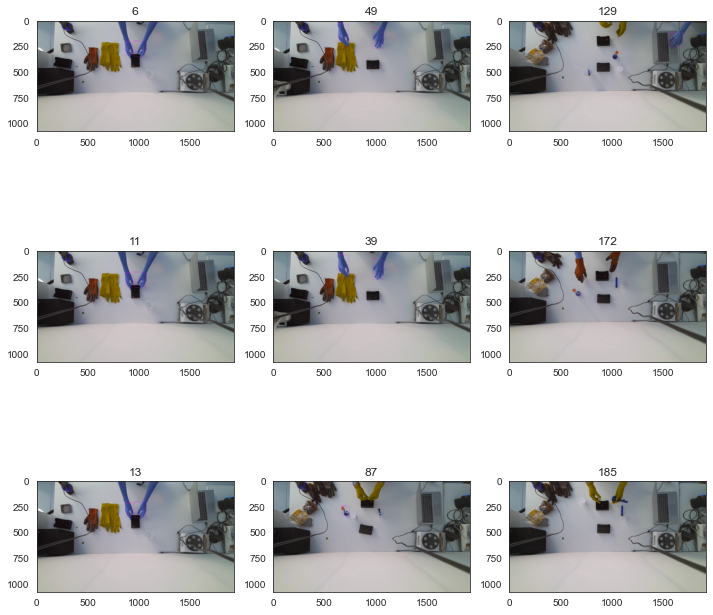

In [87]:
im7 = cv2.imread("C:/Users/pablo.cumbrera/Documents/Data/Raw DATA/OficeHand/images/testing/yolov3/processed_file_6_.jpg")
im50 = cv2.imread("C:/Users/pablo.cumbrera/Documents/Data/Raw DATA/OficeHand/images/testing/yolov3/processed_file_49_.jpg")
im130 = cv2.imread("C:/Users/pablo.cumbrera/Documents/Data/Raw DATA/OficeHand/images/testing/yolov3/processed_file_129_.jpg")
im11 = cv2.imread("C:/Users/pablo.cumbrera/Documents/Data/Raw DATA/OficeHand/images/testing/yolov3/processed_file_10_.jpg")
im39 = cv2.imread("C:/Users/pablo.cumbrera/Documents/Data/Raw DATA/OficeHand/images/testing/yolov3/processed_file_38_.jpg")
im172 = cv2.imread("C:/Users/pablo.cumbrera/Documents/Data/Raw DATA/OficeHand/images/testing/yolov3/processed_file_71_.jpg")
im14 = cv2.imread("C:/Users/pablo.cumbrera/Documents/Data/Raw DATA/OficeHand/images/testing/yolov4t/processed_file_13_.jpg")
im88 = cv2.imread("C:/Users/pablo.cumbrera/Documents/Data/Raw DATA/OficeHand/images/testing/yolov4t/processed_file_87_.jpg")
im186 = cv2.imread("C:/Users/pablo.cumbrera/Documents/Data/Raw DATA/OficeHand/images/testing/yolov4t/processed_file_185_.jpg")
sns.set_style("white")
fig = plt.figure(figsize=(12,12))
plt.subplot(331)
plt.title('6')
plt.imshow(im7)

plt.subplot(332)
plt.title('49')
plt.imshow(im50)

plt.subplot(333)
plt.title('129')
plt.imshow(im130)

plt.subplot(334)
plt.title('11')
plt.imshow(im7)

plt.subplot(335)
plt.title('39')
plt.imshow(im50)

plt.subplot(336)
plt.title('172')
plt.imshow(im172)

plt.subplot(337)
plt.title('13')
plt.imshow(im7)

plt.subplot(338)
plt.title('87')
plt.imshow(im88)

plt.subplot(339)
plt.title('185')
plt.imshow(im186)

plt.savefig("manosgrid.pdf")

print("Archivo guardado en 'manosgrid.pdf'")

In [89]:
#TESTEO DE IMAGENES INDIVIDUALES

img_hand_path= r"C:/Users/pablo.cumbrera/Documents/Data/Raw DATA/OficeHand/images/testing/yolov3/processed_file_6_.jpg"

Mostrando Imagen desde el path indicado para testeo:  
 (Archivo guardado en 'manofig.pdf')


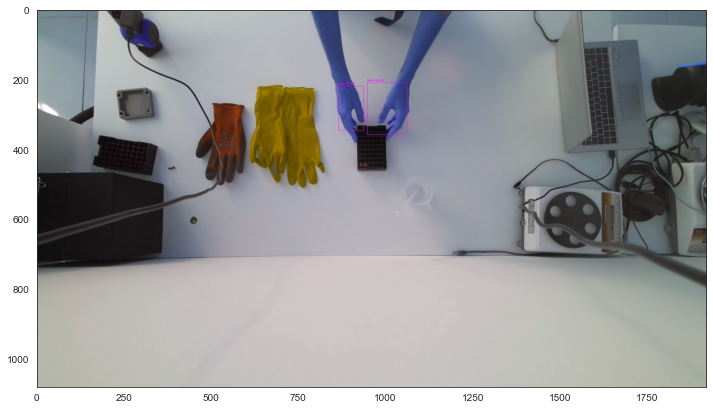

In [91]:
#TESTEO DE IMAGENES INDIVIDUALES

im = cv2.imread(img_hand_path)
print("Mostrando Imagen desde el path indicado para testeo: ", "\n (Archivo guardado en 'manofig.pdf')")
fig = plt.figure(figsize=(12,12))
plt.imshow(im)
plt.savefig("manofig.pdf")

### Exploratory Data Analaysis
___

- ¿En cuántas imagenes ha detectado cada modelo 0 elementos?

Número de imágenes señaladas con 0 elementos (Independientemente de falsos positivos):
Yolov3 : Visto 133  No Visto:  62
Yolov3 Tiny: Visto 163  No Visto:  32
Yolov3pnr:  Visto 157  No Visto:  38
Yolov4 Tiny:  Visto 105  No Visto:  90

Archivo guardado en 'imagenescero.pdf'


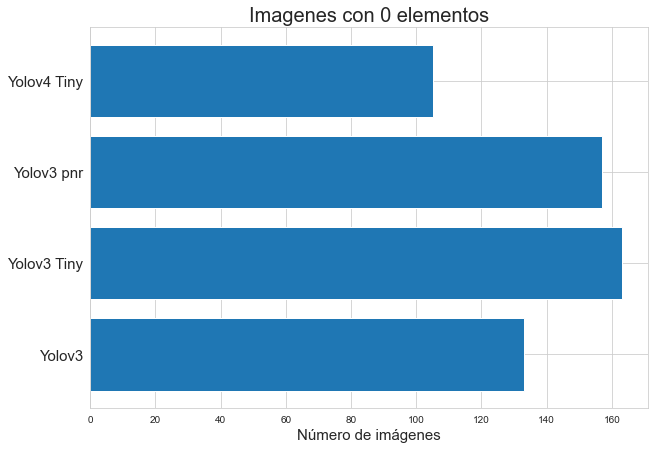

In [95]:
#DATA 
print("Número de imágenes señaladas con 0 elementos (Independientemente de falsos positivos):")
a=195-133
b=195-163
c=195-157
d=195-105
print("Yolov3 : Visto",133, " No Visto: ",a)
print("Yolov3 Tiny: Visto",163, " No Visto: ",b)
print("Yolov3pnr:  Visto",157, " No Visto: ",c)
print("Yolov4 Tiny:  Visto",105, " No Visto: ",d)

print("\nArchivo guardado en 'imagenescero.pdf'")

# Create a Figure and an array of subplots with 2 rows and 2 columns
sns.set_style("whitegrid")
fig = plt.figure(figsize=(10,7))
Modelos = ("Yolov3", "Yolov3 Tiny", "Yolov3 pnr", "Yolov4 Tiny")
posicion_y = np.arange(len(Modelos))
unidades = (133, 163, 157, 105)
unidades2 = (a,b,c,d)
plt.barh(posicion_y, unidades, align = "center", label="0 elementos")
plt.yticks(posicion_y, Modelos,fontsize=15)
plt.xlabel('Número de imágenes',fontsize=15)
plt.title("Imagenes con 0 elementos",fontsize=20)
fig.savefig("imagenescero.pdf")
plt.show()


- Hemos visto que Yolov4 Tiny da más detecciones... Ahora, ¿Cuál es el grado de confusión de Yolov4?

Yolov4 Tiny: (Falsos positivos, Falsos Positivos Parciales y Falsos Negativos)
    FP  FPp   FN  Total
0  19    9  114    195

Archivo guardado en 'imagenescero.pdf'


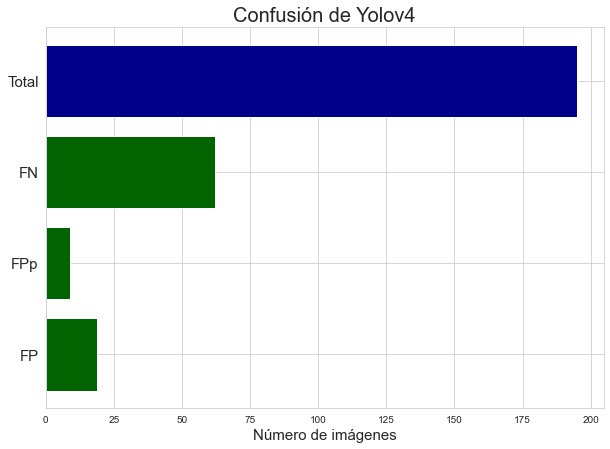

In [93]:
Yolov4_fp_fpp_fn = {'FP':19,'FPp':9,'FN':114,'Total':195}
dfy4 = pd.DataFrame([Yolov4_fp_fpp_fn], index=None)

print("Yolov4 Tiny: (Falsos positivos, Falsos Positivos Parciales y Falsos Negativos)\n",dfy4)
print("\nArchivo guardado en 'imagenescero.pdf'")

# Create a Figure and an array of subplots with 2 rows and 2 columns
fig = plt.figure(figsize=(10,7))
sns.set_style("whitegrid")
Modelos = ("FP", "FPp", "FN","Total")
posicion_y = np.arange(len(Modelos))
unidades = (19, 9, 62,195)
plt.barh(posicion_y, unidades, align = "center", label="0 elementos",color=['darkgreen','darkgreen','darkgreen','darkblue'])
plt.yticks(posicion_y, Modelos,fontsize=15)
plt.xlabel('Número de imágenes',fontsize=15)
plt.title("Confusión de Yolov4",fontsize=20)
fig.savefig("confusion_yv4t.pdf")
plt.show()

- ¿Cuántos elementos han detectado los modelos? (Por imagen - independientemente de erroneas o no)

¿Cúantas manos ha visto el modelo?- (por imagen y número de elementos, sin tener en cuenta errores)
Yolov3 :
 [0]    133
[1]     39
[2]     23
Name: elements, dtype: int64
Yolov3 Tiny: 
 [0]    163
[1]     25
[2]      7
Name: elements, dtype: int64
Yolov3pnr: 
 [0]    157
[1]     38
Name: elements, dtype: int64
Yolov4 Tiny: 
 [0]    105
[1]     55
[2]     33
[3]      2
Name: elements, dtype: int64

Archivo guardado en 'elementcounts.pdf'


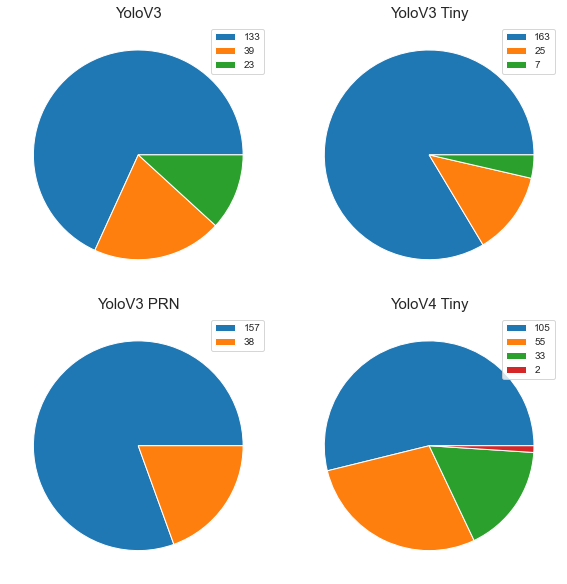

In [80]:
#Data
def countingelements(df):
    return df['elements'].value_counts()

a=countingelements(yolov3_df)
b=countingelements(yolov3t_df)
c=countingelements(yolov3prn_df)
d=countingelements(yolov4t_df)

print("¿Cúantas manos ha visto el modelo?- (por imagen y número de elementos, sin tener en cuenta errores)")
print("Yolov3 :\n",a)
print("Yolov3 Tiny: \n",b)
print("Yolov3pnr: \n",c)
print("Yolov4 Tiny: \n",d)

print("\nArchivo guardado en 'elementcounts.pdf'")


# Create a Figure and an array of subplots with 2 rows and 2 columns
figg = plt.figure(figsize=(8,8),constrained_layout=True)
ax = figg.subplots(2,2)

fig.suptitle('Número de elementos visto por el modelo (elmentos/imagen)',fontsize=15)
ax[0, 0].pie(a)
ax[0,0].set_title("YoloV3",fontsize=15)
ax[0,0].legend(a,loc="best",)

ax[0, 1].pie(b)
ax[0,1].set_title ("YoloV3 Tiny",fontsize=15)
ax[0,1].legend(b,loc="best")

ax[1, 0].pie(c)
ax[1,0].set_title ("YoloV3 PRN",fontsize=15)
ax[1,0].legend(c,loc="best")

ax[1, 1].pie(d)
ax[1,1].set_title ("YoloV4 Tiny",fontsize=15)
ax[1,1].legend(d,loc="best")


figg.savefig("Elementcounts.pdf")
plt.show()

- ¿Cómo ha sido la confusión de los modelos? (Falsos positivos, falsos negativos)

Exploración datos de detección y confusión- (por imagen y número de elementos)
Coincidencias totales    Coincidencias  No coincidencias  Total
0             20               175    195
Coincidencias en 3 modelos)    Coincidencias  No coincidencias  Total
0             17               178    195
Yolov4 Tiny: (Falsos positivos, Falsos Positivos Parciales y Falsos Negativos)
    Coincidencias  No coincidencias  Total
0             37               158    195

Archivo guardado en 'confusionmatrix.pdf'


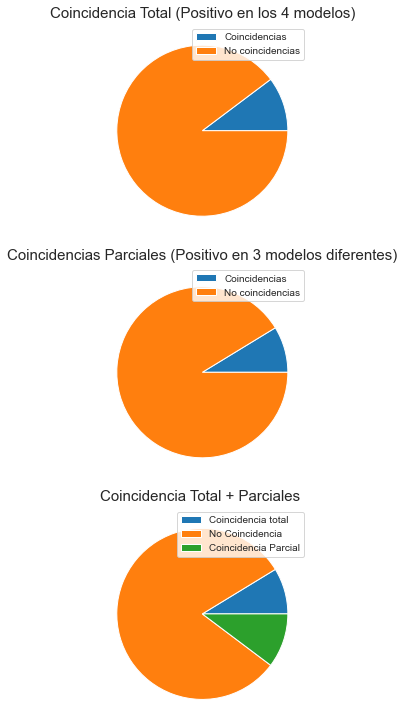

In [73]:
coincidencias_tres = {'Coincidencias':17,'No coincidencias':178,'Total':195}
dfc3 = pd.DataFrame([coincidencias_tres], index=None)
coincidencias_tot = {'Coincidencias':20,'No coincidencias':175,'Total':195}
dfct = pd.DataFrame([coincidencias_tot], index=None)
coincidencias_tres_tot = {'Coincidencias':37,'No coincidencias':158,'Total':195}
dfc3t = pd.DataFrame([coincidencias_tres_tot], index=None)

#Data
a=dfct
b=dfc3
c=dfc3t

print("Exploración datos de detección y confusión- (por imagen y número de elementos)")
print("Coincidencias totales",a)
print("Coincidencias en 3 modelos)",b)
print("Yolov4 Tiny: (Falsos positivos, Falsos Positivos Parciales y Falsos Negativos)\n",c)

print("\nArchivo guardado en 'confusionmatrix.pdf'")


# Create a Figure and an array of subplots with 2 rows and 2 columns

figg = plt.figure(figsize=(10,10),constrained_layout=True)
ax = figg.subplots(3, 1)

ax[0].pie([20,175])
ax[0].set_title("Coincidencia Total (Positivo en los 4 modelos)",fontsize=15)
ax[0].legend(a,loc="best",)

ax[1].pie([17,178])
ax[1].set_title ("Coincidencias Parciales (Positivo en 3 modelos diferentes)",fontsize=15)
ax[1].legend(b,loc="best")

ax[2].pie([17,158,20])
ax[2].set_title ("Coincidencia Total + Parciales ",fontsize=15)
ax[2].legend(["Coincidencia total","No Coincidencia","Coincidencia Parcial"],loc="best")

figg.savefig("coincidencias.pdf")
plt.show()

- ¿Cuál son los tiempos máximos y mínimos de los modelos?

Tiempos máximos:  YV3 0.51 TIN 1.41 PRN 0.02 V4T 0.05
Tiempos mínimos:  YV3 1.41 TIN 0.05 PRN 0.08 V4T 0.07
A
rchivo guardado en 'maxmin_time.pdf'


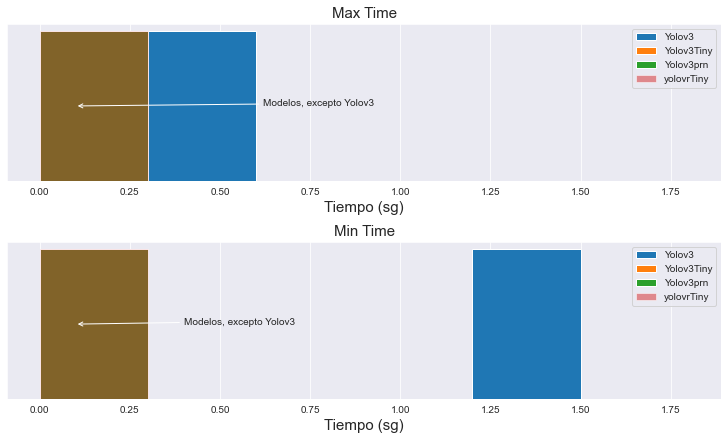

In [51]:
#Data
sns.set_style("darkgrid")
def getmintime(df):
    return df['time'].min()
def getmaxtime(df):
    return df['time'].max()

a=getmintime(yolov3_df)
c=getmintime(yolov3t_df)
e=getmintime(yolov3prn_df)
g=getmintime(yolov4t_df)

b=getmaxtime(yolov3_df)
d=getmaxtime(yolov3t_df)
f=getmaxtime(yolov3prn_df)
h=getmaxtime(yolov4t_df)
print("Tiempos máximos: ", "YV3",a,"TIN",b,"PRN",c,"V4T",d)
print("Tiempos mínimos: ", "YV3",b,"TIN",d,"PRN",f,"V4T",h)
maxtime_list=[a,c,e,g]
label_list=['Yolov3','Yolov3Tiny','Yolov3prn','yolovrTiny']
mintime_list=[b,d,f,h]

print("A\nrchivo guardado en 'maxmin_time.pdf'")

#Create a Figure and an array of subplots with 2 rows and 2 columns


figg = plt.figure(figsize=(10,6),constrained_layout=True)
ax = figg.subplots(2, 1)


bins_list = [0, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8]

ax[0].hist(a,bins=bins_list)
ax[0].hist(c,bins=bins_list)
ax[0].hist(e,bins=bins_list)
ax[0].hist(g,bins=bins_list,alpha=0.5)
ax[0].set_title("Max Time",fontsize=15)
ax[0].set_xlabel("Tiempo (sg)",fontsize=15)
ax[0].set_yticks(())
ax[0].legend(label_list, loc= "upper right")
ax[0].annotate("Modelos, excepto Yolov3", xy=(0.1, 0.5), xytext=(0.62, 0.5),arrowprops=dict(arrowstyle="->"))


ax[1].hist(b,bins=bins_list)
ax[1].hist(d,bins=bins_list)
ax[1].hist(f,bins=bins_list)
ax[1].hist(h,bins=bins_list,alpha=0.5)
ax[1].set_title ("Min Time",fontsize=15)
ax[1].set_xlabel("Tiempo (sg)",fontsize=15)
ax[1].set_yticks(())
ax[1].legend(label_list,loc= "upper right")
ax[1].annotate("Modelos, excepto Yolov3", xy=(0.1, 0.5), xytext=(0.4, 0.5),arrowprops=dict(arrowstyle="->"))



figg.savefig("maxmin_time.pdf")
plt.show()

- ¿Cuál es el tiempo medio de procesamiento del set de imágenes?

Tiempo total en procesamiento del set de imagenes: 
Yolov3 126.5
Yolov3Tiny 5.87
Yolov3prn 4.41
Yolov4 Tiny 7.409999999999998

Archivo guardado en 'Timecounts.pdf'


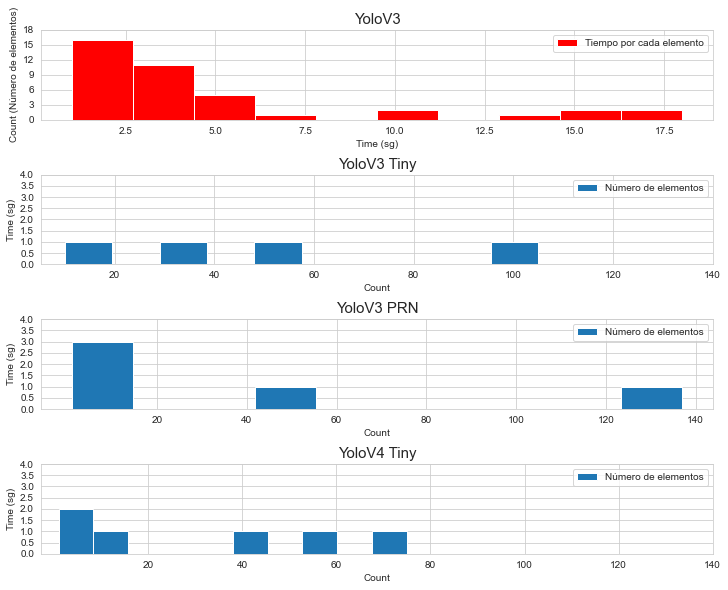

In [55]:
#DATA
a=yolov3_df['time'].value_counts()
b=yolov3t_df['time'].value_counts()
c=yolov3prn_df['time'].value_counts()
d=yolov4t_df['time'].value_counts()

print("Tiempo total en procesamiento del set de imagenes: ")
print("Yolov3", yolov3_df['time'].sum())
print("Yolov3Tiny", yolov3t_df['time'].sum())
print("Yolov3prn", yolov3prn_df['time'].sum())
print("Yolov4 Tiny",yolov4t_df['time'].sum())

print("\nArchivo guardado en 'Timecounts.pdf'")

# Create a Figure and an array of subplots with 2 rows and 2 columns
sns.set_style("whitegrid")
f = plt.figure(figsize=(10,8),constrained_layout=True)
ax = f.subplots(4, 1)
ax[0].hist(a,bins=10,color="red")
ax[0].set_title("YoloV3",fontsize=15)
ax[0].set_xlabel("Time (sg)")
ax[0].set_ylabel("Count (Número de elementos)")
ax[0].legend(['Tiempo por cada elemento'])
ax[0].set_yticks([0,3,6,9,12,15,18])

ax[1].hist(b,bins=10)
ax[1].set_title ("YoloV3 Tiny",fontsize=15)
ax[1].set_xlabel("Count")
ax[1].set_ylabel("Time (sg)")
ax[1].legend(['Número de elementos'])
ax[1].set_yticks([0,0.5,1,1.5,2,2.5,3,3.5,4])
ax[1].set_xticks([20,40,60,80,100,120,140])

ax[2].hist(c,bins=10)
ax[2].set_title ("YoloV3 PRN",fontsize=15)
ax[2].set_xlabel("Count")
ax[2].set_ylabel("Time (sg)")
ax[2].legend(['Número de elementos'])
ax[2].set_yticks([0,0.5,1,1.5,2,2.5,3,3.5,4])
ax[2].set_xticks([20,40,60,80,100,120,140])

ax[3].hist(d,bins=10)
ax[3].set_title ("YoloV4 Tiny",fontsize=15)
ax[3].set_xlabel("Count")
ax[3].set_ylabel("Time (sg)")
ax[3].legend(['Número de elementos'])
ax[3].set_yticks([0,0.5,1,1.5,2,2.5,3,3.5,4])
ax[3].set_xticks([20,40,60,80,100,120,140])

f.savefig("Timecounts.pdf")
plt.show()

#### Conclusiones
___

#### Elección de modelo
Pese a la confusión que parece tener, el modelo "YoloV4 Tiny" parece el más adecuado para la tarea descrita. No obstante, probaremos a realizar un entrenamiento adicional aumentando el dataset, dando lugar a más generalizaciones.

#### A tener en cuenta y propuestas
Algunas de las detecciones positivas se han realizado a partir de elementos que acompañan normalmente a las manos, en este caso, relojes.
   
   - Proponemos la posibilidad de incorporar a la muñeca del individuo un elemento facilmente distinguible que aumentara nuestro rendimiento.

#### Limitaciones
No se ha tenido en cuenta la presencia o ausencia de guantes